In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
import syndata
import align
import mgplvm
from mgplvm import kernels, rdist
from mgplvm.manifolds import Torus
from mgplvm.models import Core
from mgplvm.training import train
from mgplvm.lpriors import AR1
plt.rcParams.update({'font.size': 22})

In [2]:
torch.set_default_dtype(torch.float64)
device = mgplvm.utils.get_device("cuda")  # get_device("cpu")

d = 1  # dims of latent space
n = 100 # number of neurons
m = 100  # number of conditions / time points
n_z = 15  # number of inducing points
n_samples = 1  # number of samples
gen = syndata.Gen(syndata.Torus(d), n, m, variability=0.25)

sig0 = 1.5
l = 0.4
gen.set_param('l', l)
Y = gen.gen_data()
print('mean activity:', np.mean(Y))
Y = Y + np.random.normal(size=Y.shape) * np.mean(Y) / 3
d = 1
# specify manifold, kernel and rdist
manif = Torus(m, d)
ref_dist = mgplvm.rdist.MVN(m, d, sigma=sig0)
ar1_lprior = AR1(manif)
print(ar1_lprior.autocorr)
print(ar1_lprior.process_var)
# initialize signal variance
alpha = np.mean(np.std(Y, axis=1), axis=1)
kernel = kernels.QuadExp(n, manif.distance, alpha=alpha)
# generate model
sigma = np.mean(np.std(Y, axis=1), axis=1)  # initialize noise
mod = Core(manif, n, m, n_z, kernel, ref_dist, sigma=sigma, lprior=ar1_lprior).to(device)

mean activity: 0.31095971223764535
tensor([1.4427], grad_fn=<ExpBackward>)
tensor([1.3333], grad_fn=<ExpBackward>)


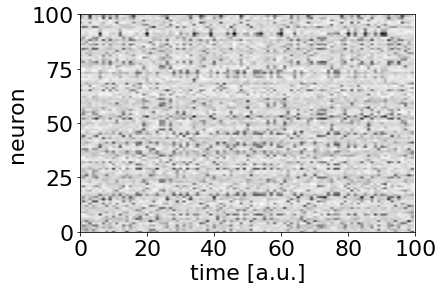

In [3]:
plt.figure()
Yplot = Y[:, :, 0]
plt.imshow(Yplot, cmap='Greys', aspect='auto')
plt.xlabel("time [a.u.]")
plt.ylabel("neuron")
plt.xlim(0,100)
plt.ylim(0,n)
plt.show()
plt.close()

In [4]:
# train model
trained_mod = train(Y,
                    mod,
                    device,
                    optimizer=optim.Adam,
                    outdir='none',
                    max_steps=1000,
                    burnin='default',
                    n_b=64,
                    lrate=1E-2,
                    print_every=50)

data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
mod = mod.to(device)
mulearn = mod.manif.prms.data.cpu()
mutrue = gen.gs[0]
plearn = mod.manif.distance(mulearn.T, mulearn.T).numpy()
ptrue = gen.manifold.manifs[0].distance(mutrue, mutrue)
ptrue, plearn = [p.flatten() for p in [ptrue, plearn]]

final importance weighted log likelihood: 0.2913


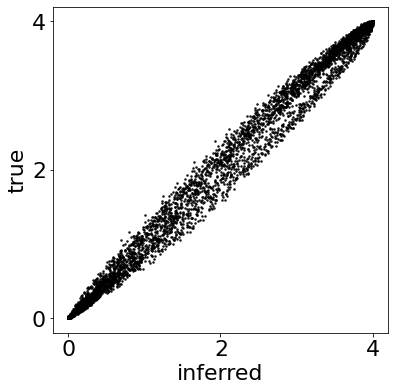

In [5]:
print('final importance weighted log likelihood: %.4f' % mod.calc_LL(data, 128).item())
plt.figure(figsize=(6, 6))
plt.plot(plearn, ptrue, "ko", markersize=1.5, alpha=0.5)
plt.xlabel("inferred")
plt.ylabel("true")
plt.xticks((0, 2, 4), ("$0$", "$2$", "$4$"))
plt.yticks((0, 2, 4), ("$0$", "$2$", "$4$"))
plt.show()
plt.close()

In [6]:
#align model to ground truth
mod = align.align_torus(mod, gen.gs[0])

# %% compute mse
query = mod.manif.mu.detach()
fmean, fstd = mod.predict(data, query, niter=100)
var = np.mean(np.var(Y, axis=1))
MSE = np.mean(((fmean - data)**2).cpu().numpy())
print('MSE:', MSE, 'var:', var)

coordinate system: [[-1]] 0 loss: 0.004090155015380379
coordinate system: [[-1]] 1 loss: 0.004090154785172831
coordinate system: [[-1]] 2 loss: 0.004090154785174256
coordinate system: [[-1]] 3 loss: 0.004090154799597627
coordinate system: [[-1]] 4 loss: 0.004090154795025676
coordinate system: [[1]] 0 loss: 1.6557577746248435
coordinate system: [[1]] 1 loss: 1.6557577746248469
coordinate system: [[1]] 2 loss: 1.6557577746248415
coordinate system: [[1]] 3 loss: 1.655757774625539
coordinate system: [[1]] 4 loss: 1.6557577746248446
MSE: 0.01923663975796918 var: 0.10579505855332016


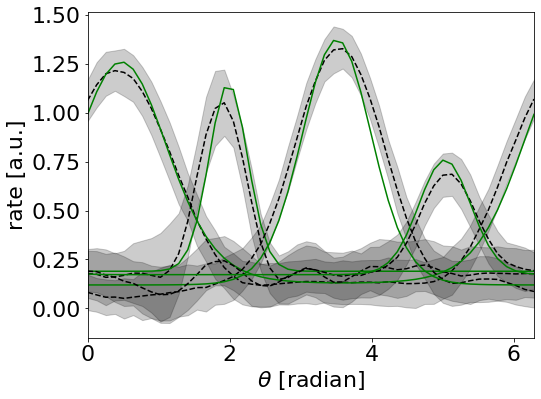

In [7]:
#%% consider 'tuning curves'
query = torch.tensor(np.linspace(0, 2 * np.pi, 50),
                     dtype=torch.get_default_dtype(),
                     device=device)

fmean, fstd = mod.predict(data, query, niter=100)
inds = [np.argmin((gen.gprefs[0] - val)**2) for val in 0.5 + np.arange(4) * 1.5]
plt.figure(figsize=(8, 6))

for i in inds:
    xs, m, std = [arr.cpu().numpy() for arr in [query, fmean, fstd]]
    m, std = [arr[i, :, 0] for arr in [m, std]]
    plt.plot(xs, m, "k--")
    plt.fill_between(xs, m - 2 * std, m + 2 * std, color='k', alpha=0.2)
    true_y = gen.gen_data(gs_in=[xs.reshape(-1, 1)], sigma=np.zeros((mod.n, 1)))
    plt.plot(xs, true_y[i, :, 0], 'g-')

plt.xlabel(r"$\theta$ [radian]")
plt.ylabel(r"rate [a.u.]")
plt.xlim(0, 2 * np.pi)
plt.show()
plt.close()

In [8]:
ar1_lprior.autocorr

tensor([0.1688], device='cuda:0', grad_fn=<ExpBackward>)

In [9]:
ar1_lprior.process_noise

AttributeError: 'AR1' object has no attribute 'process_noise'